# FOXSI-2 FeXVII Sources exploration
### Feb 2020, Milo BC @ Berkeley

In [1]:
from sunpy.time import TimeRange
from glob import glob
from sunpy.map import Map
from scipy import ndimage
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import astropy.units as u

In [6]:
# FOXSI-2 List of Targets an Times
Ftarget = {'cen1_pos0':(359.0, -431.0), # arcsec
           'cen1_pos1':(-1.0, -431.0),
           'cen1_pos2':(-1.0, -251.0),
           'cen2_pos0':(-1.0, -281.0),
           'cen2_pos1':(-390.0, -281.0),
           'cen3_pos0':(1210.5, -431.5),
           'cen3_pos1':(850.0, -431.5),
           'cen3_pos2':(850.0, -251.0),
           'cen4':(200.0, 750.0),
           'cen5':(0.0, -251.0),
           'cen_Iris':(11,-260)}
Ftimes = {'cen1_pos0': TimeRange(['2014-12-11 19:12:42', '2014-12-11 19:13:14.3']),
          'cen1_pos1':TimeRange(['2014-12-11 19:13:18','2014-12-11 19:13:42.6']),
          'cen1_pos2':TimeRange(['2014-12-11 19:13:46.5','2014-12-11 19:14:25']),
          'cen2_pos0':TimeRange(['2014-12-11 19:14:29','2014-12-11 19:14:39.6']),
          'cen2_pos1':TimeRange(['2014-12-11 19:14:44','2014-12-11 19:15:36.7']),
          'cen3_pos0':TimeRange(['2014-12-11 19:15:40.6','2014-12-11 19:16:07.2']),
          'cen3_pos1':TimeRange(['2014-12-11 19:16:11','2014-12-11 19:16:30.1']),
          'cen3_pos2':TimeRange(['2014-12-11 19:16:34','2014-12-11 19:17:09.2']),
          'cen4':TimeRange(['2014-12-11 19:17:13.5','2014-12-11 19:18:46.2']),
          'cen5':TimeRange(['2014-12-11 19:18:50.5','2014-12-11 19:19:23.2']),
          't_shtr':TimeRange(['2014-12-11 19:18:18','2014-12-11 19:18:22']),
          'Iris_Obs':TimeRange(['2014-12-11 19:12:22','2014-12-11 19:39:01'])}
# Reading AIA Maps:
data_dir = '/Volumes/Pandora/FOXSI/AIA/'
str_indices = {'94':'', '131':'', '171':'', '193':'', '211':'', '304':'', '335':'', '1600':'', '1700':''}
file_list = {}

for key in str_indices:
    file_list.update({key: glob(data_dir + '*' + key + '*.fits')})
    file_list[key]=sorted(file_list[key])
# selecting only files for FOXSI-2 
frame_i, frame_f = 62, 96 # covers from cen1pos0 init to cen5 end.
#frame_i, frame_f = 62, 65 # covers from cen1pos0 init to cen5 end.
F_AIA094 = file_list['94'][frame_i:frame_f+1]
F_AIA171 = file_list['171'][frame_i:frame_f+1]
F_AIA211 = file_list['211'][frame_i:frame_f+1]

In [7]:
mapsFe18 = []
for f094, f171, f211 in zip(F_AIA094,F_AIA171,F_AIA211):
    m094  = Map(f094)
    m171  = Map(f171)
    m211  = Map(f211)
    data  = m094.data[:] - m211.data[:]/120 - m171.data[:]/450
    datag = ndimage.gaussian_filter(data, 20)
    mFe18 = Map(datag, m171.meta)
    mapsFe18.append(mFe18)

In [8]:
#def allfov(t):
for t in range (1,frame_f-frame_i): 
    fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection=mapsFe18[t]));
    mapsFe18[t].plot_settings['norm'] = colors.Normalize()
    mapsFe18[t].plot(vmin=10,vmax=20,cmap='viridis')
    mapsFe18[t].draw_limb()
    ax.set_title('FeXVIII '+mapsFe18[t].meta['date-obs'][:-3],fontsize=26)
    plt.colorbar()
    fig.savefig('/Users/Kamilobu/Desktop/temporal/FeXVIII'+str(t)+'.png',bbox_inches="tight")

IndexError: list index out of range

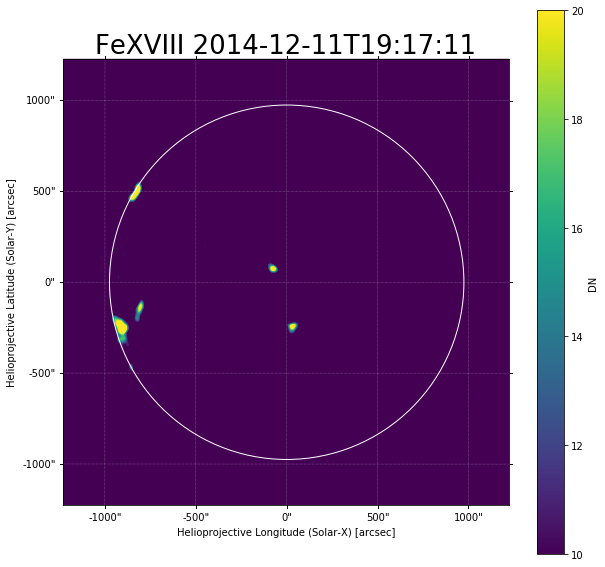

In [11]:
t = 23
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection=mapsFe18[t]));
mapsFe18[t].plot_settings['norm'] = colors.Normalize()
mapsFe18[t].plot(vmin=10,vmax=20,cmap='viridis')
mapsFe18[t].draw_limb()
ax.set_title('FeXVIII '+mapsFe18[t].meta['date-obs'][:-3],fontsize=26)
plt.colorbar(label=mapsFe18[t].meta['pixlunit'])
plt.show()

In [34]:
# Enumerating the sources
labels, n = ndimage.label(mapsFe18[t].data > 14)

In [99]:
# taken from foxsisoft :
offset_xy = (360.,-180.)
cen4 = (-160.  + offset_xy[0] , 930. + offset_xy[1] )

sources = []
for l in range(1,n+1):
    l1 = mapsFe18[t].data*(labels==l)
    pixel_pos = ndimage.center_of_mass(l1) * u.pixel
    hpc_max = mapsFe18[t].pixel_to_world(pixel_pos[1], pixel_pos[0])
    sources.append((round(hpc_max.Tx.value-cen4[0],1), round(hpc_max.Ty.value-cen4[1],1)))

In [100]:
sources

[(-1112.7, -1006.8),
 (-170.4, -997.5),
 (-1011.0, -900.7),
 (-278.4, -677.4),
 (-1032.5, -260.8)]

In [110]:
arcmin = np.array(sources)/60 # in arcmin

In [122]:
np.sqrt(arcmin[:,0]**2 + arcmin[:,1]**2)

array([25.00970662, 16.8658301 , 22.56706973, 12.20629755, 17.74880974])

In [125]:
cen4[0]/60,cen4[1]/60

(3.3333333333333335, 12.5)

In [126]:
cen4

(200.0, 750.0)

## Coordenadas del centro de T4 ??? 
hacer la resta con los centros de masa para cada fuente.

In [98]:
# taken from foxsisoft :
offset_xy = (360.,-180.)
cen4 = (-160.  + offset_xy[0] , 930. + offset_xy[1] )
cen4

(200.0, 750.0)

In [ ]:
mask = fd.data < fd.max() * 0.08
data2 = ndimage.gaussian_filter(fd.data * ~mask, 40)
#data2[data2 < 100] = 0
fd2 = sunpy.map.Map(data2, fd.meta)
labels, n = ndimage.label(fd2.data)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12),subplot_kw=dict(projection=fd))
fd.plot()
fd.plot_settings['norm'] = colors.Normalize()
fd.plot(cmap='gnuplot2_r',vmin=0,vmax=100)
plt.colorbar(label=fd.meta['pixlunit'])
plt.contour(labels)
plt.figtext(0.3, 0.2, f'Number of regions = {n}', color='white')
plt.title('AIA FeXVIII - '+fd.meta['t_obs'][:-4],fontsize='28')
ax.tick_params(labelsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(data2,origin='lower')